In [160]:
import glob
from sklearn.model_selection import train_test_split
from Metrics.FourierAnalysisMaster.pspec import rgb_2_darter
import cv2
import numpy as np
import imageio
import matplotlib.pyplot as plt
import os
from tensorflow.keras.models import Model
import tensorflow as tf
import tensorflow.keras as K
import pandas as pd
import seaborn as sns
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Conv2D, MaxPool2D, Softmax, Dense, Flatten, Reshape, Conv2DTranspose, UpSampling2D, ZeroPadding2D

# Preparing the habitat data

listing the environment images

In [161]:
HAB_SPECIE = "blennioides"

habitat_path = glob.glob("../Images/Habitats/{}/*/*.tif".format(HAB_SPECIE))
print(len(habitat_path))

50


preprocessing the images by resizing them, and transforming them into the darter luminance space, then normalizing

In [162]:
def preprocess_habitat_image(image, new_dsize, to_darter=True):
    image = cv2.resize(image, dsize=(new_dsize[::-1]), interpolation=cv2.INTER_CUBIC)
    if to_darter:
        image = rgb_2_darter(image)
        image = image[..., 0]+image[..., 1]
        image = image[..., np.newaxis]
    else:
        image = image/np.max(image)
    return image

In [163]:
WIDTH_IMG=600
HEIGHT_IMG=400
CHANNELS_IMG=3

habitat_img = np.empty(shape=(len(habitat_path), HEIGHT_IMG, WIDTH_IMG, CHANNELS_IMG))
for i, path in enumerate(habitat_path):
    img = imageio.imread(path)
    habitat_img[i] = preprocess_habitat_image(img, (HEIGHT_IMG, WIDTH_IMG), CHANNELS_IMG==1)

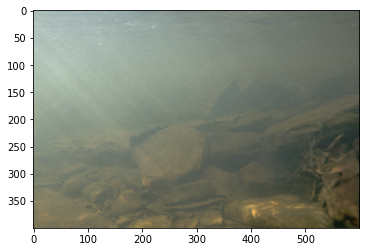

float64


In [164]:
%matplotlib inline
plt.imshow(habitat_img[0], cmap='gray')
plt.show()
print(habitat_img.dtype)

Splitting the data between train and test

In [165]:
print("number of habitat images: ", habitat_img.shape[0])
train, test = train_test_split(habitat_img, train_size=0.8, shuffle=True)
print("train: {}, test: {}".format(train.shape[0], test.shape[0]))

number of habitat images:  50
train: 40, test: 10


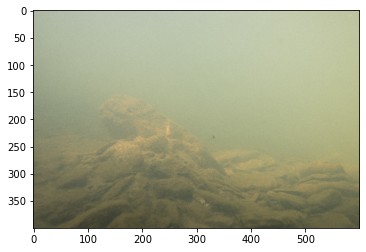

In [166]:
plt.imshow(train[np.random.randint(0, len(train))])
plt.show()

Doing data augmentation and normalization

In [167]:
PREDICTION_SIZE = 128

In [168]:
def fly_over_image(image, window=(PREDICTION_SIZE, PREDICTION_SIZE), stride=PREDICTION_SIZE//5, return_coord=False):
    img_Y = image.shape[-2]
    img_X = image.shape[-3]
    for start_x in range(0, img_X-window[0]+1, stride):
        for start_y in range(0, img_Y-window[1]+1, stride):
            if return_coord:
                yield (start_x, start_x+window[0], start_y, start_y+window[1])
            else:
                sample = image[start_x: start_x+window[0], start_y: start_y + window[1]]
                yield sample
            
def mirror(image):
    return [image, np.flip(image, axis=(-2))]

def augment(set_img):
    augmented = []
    for idx, img in enumerate(set_img):
        for sample in fly_over_image(img, (PREDICTION_SIZE, PREDICTION_SIZE), PREDICTION_SIZE):
            augmented += mirror(sample)
    augmented = np.array(augmented)
    return augmented

def normalize(set_img):
    #set_img = (set_img - np.mean(set_img)) / np.std(set_img)
    return (set_img - np.min(set_img)) / (np.max(set_img) - np.min(set_img)) 
    

In [169]:
test = augment(test)
test = normalize(test)

train = augment(train)
train = normalize(train)

print("train: {}, test: {}".format(train.shape[0], test.shape[0]))

train: 960, test: 240


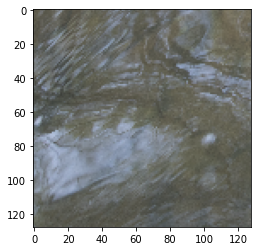

In [176]:
plt.imshow(train[np.random.randint(0, len(train))])
plt.show()

# Preparing the Auto encoder

In [177]:
LATENT_DIM=200
BATCH_SIZE=70
EPOCHS=30

model 1: perceptron

In [178]:
K.backend.clear_session()

class Autoencoder(Model):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential([
            Flatten(),
            Dense(latent_dim, activation='relu')
        ])
        self.decoder = tf.keras.Sequential([
            Dense(PREDICTION_SIZE*PREDICTION_SIZE*CHANNELS_IMG, activation='sigmoid'),
            Reshape((PREDICTION_SIZE, PREDICTION_SIZE, CHANNELS_IMG))
        ])
        
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = Autoencoder(LATENT_DIM)

autoencoder.compile(optimizer='adam', loss='mse')# K.losses.MeanSquaredError())

model 2: perceptron with convolutions

In [ ]:
K.backend.clear_session()

class Autoencoder(Model):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential([

        ])
        self.decoder = tf.keras.Sequential([

        ])
        
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = Autoencoder(LATENT_DIM)

autoencoder.compile(optimizer='adam', loss='mse')# K.losses.MeanSquaredError())

model 3: with VGG

In [155]:
K.backend.clear_session()

class Autoencoder(Model):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential([
            VGG16(weights='imagenet', include_top=False, 
                             input_shape=(PREDICTION_SIZE, PREDICTION_SIZE, CHANNELS_IMG)),
            Conv2D(filters=latent_dim, kernel_size=3, name="middle_layer")
        ])
        
        self.decoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(1,1,latent_dim)),
            UpSampling2D(size = (2,2), name = 'upsp1'),
            Conv2D(512, 3, activation = 'relu', padding = 'same', name = 'conv6_1'),
            Conv2D(512, 3, activation = 'relu', padding = 'same', name = 'conv6_2'),
            Conv2D(512, 3, activation = 'relu', padding = 'same', name = 'conv6_3'),

            UpSampling2D(size = (2,2), name = 'upsp2'),
            Conv2D(512, 3, activation = 'relu', padding = 'same', name = 'conv7_1'),
            Conv2D(512, 3, activation = 'relu', padding = 'same', name = 'conv7_2'),
            Conv2D(512, 3, activation = 'relu', padding = 'same', name = 'conv7_3'),
            ZeroPadding2D(padding =  ((1, 0), (1, 0)), data_format = 'channels_last', name='zero1'),

            UpSampling2D(size = (2,2), name = 'upsp3'),
            Conv2D(256, 3, activation = 'relu', padding = 'same', name = 'conv8_1'),
            Conv2D(256, 3, activation = 'relu', padding = 'same', name = 'conv8_2'),
            Conv2D(256, 3, activation = 'relu', padding = 'same', name = 'conv8_3'),

            UpSampling2D(size = (2,2), name = 'upsp4'),
            Conv2D(128, 3, activation = 'relu', padding = 'same', name = 'conv9_1'),
            Conv2D(128, 3, activation = 'relu', padding = 'same', name = 'conv9_2'),

            UpSampling2D(size = (2,2), name = 'upsp5'),
            Conv2D(64, 3, activation = 'relu', padding = 'same', name = 'conv10_1'),
            Conv2D(64, 3, activation = 'relu', padding = 'same', name = 'conv10_2'),

            Conv2D(CHANNELS_IMG, 3, activation = 'relu', padding = 'same', name = 'conv11'),
        ])
        
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = Autoencoder(LATENT_DIM)

autoencoder.compile(optimizer='adam', loss='mse')# K.losses.MeanSquaredError())

model 4 convolutional variationnal autoencoder

In [ ]:
K.backend.clear_session()

class CVAE(tf.keras.Model):
  """Convolutional variational autoencoder."""

  def __init__(self, latent_dim):
    super(CVAE, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
            tf.keras.layers.Conv2D(
                filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Conv2D(
                filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Flatten(),
            # No activation
            tf.keras.layers.Dense(latent_dim + latent_dim),
        ]
    )

    self.decoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
            tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
            tf.keras.layers.Conv2DTranspose(
                filters=64, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=32, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            # No activation
            tf.keras.layers.Conv2DTranspose(
                filters=1, kernel_size=3, strides=1, padding='same'),
        ]
    )

  @tf.function
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
    mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid=False):
    logits = self.decoder(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs
    return logits


autoencoder = Autoencoder(LATENT_DIM)
autoencoder.compile(optimizer='adam', loss='mse')# K.losses.MeanSquaredError())

checkout that model

In [179]:
autoencoder.build(input_shape=(None, PREDICTION_SIZE, PREDICTION_SIZE, CHANNELS_IMG))
autoencoder.encoder.summary()
autoencoder.decoder.summary()
#K.utils.plot_model(
#    autoencoder, expand_nested=True, show_shapes=True
#)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  9830600   
Total params: 9,830,600
Trainable params: 9,830,600
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              multiple                  9879552   
_________________________________________________________________
reshape (Reshape)            multiple                  0         
Total params: 9,879,552
Trainable params: 9,879,552
Non-trainable params: 0
_________________________________________________________________


# Training

In [183]:
history = autoencoder.fit(x=train, y=train, 
                            batch_size=BATCH_SIZE, 
                            validation_data=(test, test),
                            epochs= EPOCHS, 
                            callbacks= [],
                            shuffle= True,
                            #steps_per_epoch=200
                            )

Epoch 1/30
14/14 [==============================] - 0s 28ms/step - loss: 0.0363 - val_loss: 0.0254
Epoch 2/30
14/14 [==============================] - 0s 28ms/step - loss: 0.0362 - val_loss: 0.0253
Epoch 3/30
14/14 [==============================] - 0s 28ms/step - loss: 0.0362 - val_loss: 0.0253
Epoch 4/30
14/14 [==============================] - 0s 27ms/step - loss: 0.0361 - val_loss: 0.0253
Epoch 5/30
14/14 [==============================] - 0s 27ms/step - loss: 0.0361 - val_loss: 0.0253
Epoch 6/30
14/14 [==============================] - 0s 30ms/step - loss: 0.0360 - val_loss: 0.0253
Epoch 7/30
14/14 [==============================] - 0s 32ms/step - loss: 0.0360 - val_loss: 0.0253
Epoch 8/30
14/14 [==============================] - 0s 33ms/step - loss: 0.0360 - val_loss: 0.0252
Epoch 9/30
14/14 [==============================] - 0s 29ms/step - loss: 0.0359 - val_loss: 0.0252
Epoch 10/30
14/14 [==============================] - 0s 28ms/step - loss: 0.0359 - val_loss: 0.0252
Epoch 11/

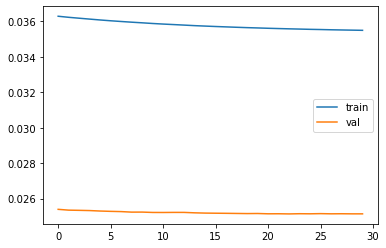

In [184]:
%matplotlib inline
plt.plot(history.history['loss'], label="train")
plt.plot(history.history['val_loss'], label="val")
plt.legend()
plt.show()

# Visualize Predictions

In [189]:
sample_test= test
prediction = autoencoder.predict(sample_test)
print(sample_test.shape, prediction.shape)

(240, 128, 128, 3) (240, 128, 128, 3)


In [190]:
%matplotlib qt
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(sample_test[i])
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(prediction[i])
    plt.title("reconstructed")
    plt.gray()
    mse=K.losses.MSE(sample_test[i], prediction[i])
    #print(mse)
    ax.set_xlabel("mse: {}".format(mse))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

# Divergence study

### Prepare fish data

In [191]:
FISH_SPECIE = "barrenense"

male_fish_path = glob.glob("../Images/Crops/{}/*_M*.tif".format(FISH_SPECIE))
female_fish_path = glob.glob("../Images/Crops/{}/*_F*.tif".format(FISH_SPECIE))

print("specie: {} / females: {} / males: {}".format(FISH_SPECIE, len(female_fish_path), len(male_fish_path)))

specie: barrenense / females: 43 / males: 42


In [193]:
def preprocess_fish_image(image, to_darter=False):
    if to_darter:
        image = rgb_2_darter(image)
        image = image[..., 0]+image[..., 1]
    image = (image-np.min(image))/(np.max(image)-np.min(image))
    return image[..., np.newaxis]

### visualize heatmap

In [209]:
def get_heat_prediction_fish(img):
    heatmap = np.zeros_like(img)
    ponderation = np.ones_like(img)
    batch = []
    for sample in fly_over_image(img, (PREDICTION_SIZE, PREDICTION_SIZE), PREDICTION_SIZE//5, False):
        batch += [sample]

    batch = np.array(batch)
    
    prediction = autoencoder.predict_on_batch(batch)
    mse = K.losses.MSE(batch, prediction)
    
    i = 0
    for x1, x2, y1, y2 in fly_over_image(img, (PREDICTION_SIZE, PREDICTION_SIZE), PREDICTION_SIZE//5, True):
        heatmap[x1:x2, y1:y2, 0] += mse[i]
        ponderation[x1:x2, y1:y2, 0] += 1
        i+=1
    return np.divide(heatmap, ponderation)

In [210]:
fishes = []
ht = []

for i, path in enumerate(male_fish_path):
    img = imageio.imread(path)
    fishes += [preprocess_fish_image(img, CHANNELS_IMG==1)]

for fish in fishes:
    ht += [get_heat_prediction_fish(fish)]


ValueError: in user code:

    /home/durrmeyer/anaconda3/envs/cefe/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1147 predict_function  *
        outputs = self.distribute_strategy.run(
    <ipython-input-178-3c1eaad4b25c>:17 call  *
        encoded = self.encoder(x)
    /home/durrmeyer/anaconda3/envs/cefe/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:927 __call__  **
        outputs = call_fn(cast_inputs, *args, **kwargs)
    /home/durrmeyer/anaconda3/envs/cefe/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:291 call
        outputs = layer(inputs, **kwargs)
    /home/durrmeyer/anaconda3/envs/cefe/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:885 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs,
    /home/durrmeyer/anaconda3/envs/cefe/lib/python3.8/site-packages/tensorflow/python/keras/engine/input_spec.py:212 assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer dense is incompatible with the layer: expected axis -1 of input shape to have value 49152 but received input with shape [0, 1]


In [ ]:
# %matplotlib qt
n = 5
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(fishes[i])
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display heatmap
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(ht[i], cmap='hot')
    plt.title("heatmap")
    plt.colorbar()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)


plt.show()

### visualize divergence

In [ ]:
def divergence(autoencoder, start, repetition, visu=False):
    if start.ndim==3:
        start=start[np.newaxis, ...]
    prev_decoded = start
    if visu: plt.figure(figsize=(20, 4))
    shift_decoded = []
    for i in range(repetition):
        if visu:
            ax = plt.subplot(repetition//10, 10, i+1)
            plt.imshow(prev_decoded[0])

        new_decoded = autoencoder.predict(prev_decoded)
        prev_decoded = new_decoded#.numpy()
        shift_decoded.append(np.mean(np.square(start - prev_decoded), axis=(-1,-2,-3)))
    if visu: plt.show()
    return shift_decoded 

x = next( fly_over_image(fishes[0], (PREDICTION_SIZE, PREDICTION_SIZE), PREDICTION_SIZE//5, False) )
shift = divergence(autoencoder, x , 50, True)
plt.plot(shift)
plt.show()

In [ ]:
def order_by_divergence(x_test, iteration ,visu=True):
    if x_test.ndim==3:
        x_test=x_test[np.newaxis, ...]
    last_shift=[]
    for i in range(iteration):
        start = x_test[np.newaxis, i]
        shift = divergence(start, iteration)
        plt.plot(shift)
        last_shift.append(shift[-1][0])
    plt.title("MSE divergence through iteration")
    plt.xlabel("iteration")
    plt.ylabel("MSE")
    plt.show()
    return x_test[np.argsort(last_shift)]

# Execute a test for all the fishes

Prepare the dataframes

In [ ]:
data = pd.read_csv("../Results/image_list.csv")
results = pd.DataFrame()
data.head()

In [ ]:
def get_divergence_metric(model, image, n_iter_max=100, epsilon=0.1):
    if image.ndim==3:
        image = image[np.newaxis, ...]
    prev_decoded = image
    shift = [0]
    iter_converged = n_iter_max
    for i in range(n_iter_max):
        new_decoded = autoencoder.predict(prev_decoded)
        prev_decoded = new_decoded
        
        diff = np.mean(np.square(image - prev_decoded), axis=(-1,-2,-3))
        shift.append(diff)
        
        if abs(shift[i+1]-shift[i]) <= epsilon:
            iter_converged = i
            return (iter_converged, max(shift), shift[-1], shift)
    print("did not converge")
    return (iter_converged, max(shift), shift[-1], shift)

In [ ]:
for idx, row in data.iterrows():
    img = imageio.imread(row["Image_path"])
    preprocessed_img = preprocess_fish_image(img)
    mid_x, mid_y = preprocessed_img.shape[0]//2, preprocessed_img.shape[1]//2
    crop = preprocessed_img[mid_x-PREDICTION_SIZE//2:mid_x+PREDICTION_SIZE//2, mid_y-PREDICTION_SIZE//2:mid_y+PREDICTION_SIZE//2]
    
    iter_stable, max_div, diff_converged, shifts = get_divergence_metric(autoencoder, crop, n_iter_max=100, epsilon=0.1)
    
    data.loc[idx, ["iter_convergence", "max_divergence", "diff_converged"]] = [iter_stable, max_div, diff_converged]
    
    for i, shift in enumerate(shifts):
        results.loc[len(results), ["iteration", "mse", "folder"]] = [i ,shift , row["folder"]] 
    
data.head()

In [ ]:
def visualize_div_metrics(data):
    sns.catplot(data=data, y="iter_convergence")
    plt.show()
    sns.catplot(data=data, y="max_divergence")
    plt.show()
    sns.catplot(data=data, y="diff_converged")
    plt.show()

visualize_div_metrics(data)

In [ ]:
def vizualize_divergence(data):
    sns.lineplot(data=data, x="iteration", y="mse", hue="folder")
    plt.show()
    
vizualize_divergence(results)
results.head()

In [ ]:
data.to_csv("../Results/divergence_metrics.csv")
result.to_csv("../Results/divergence.csv")